In [1]:
%%html
<style type="text/css">
input.good:checked + label {color: green}
input.bad:checked + label {color: red}
input.good:checked + label::after {color: green; content: ' Õige vastus!'}
input.bad:checked + label::after {color: red; content: ' Vale vastus!'}
</style>

# Mittelineaarse Pohli ringpendli simulatsioon

See tööleht näitab, kuidas saab simuleerida [Pohl'i ringpendli lisaraskuse ja välisjõuga](http://iopscience.iop.org/article/10.1088/0143-0807/35/5/055012), mis tekitab mittelineaarset võnkumist. Pendli liikumisvõrrandite lahendamiseks kasutame SciPy ja NumPy, tulemuste joonistamiseks kasutame PyPlot. Lisaks saab IPython'i abil tulemust ka kuulda.

In [2]:
%matplotlib inline

from scipy.integrate import odeint
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio

## Pendli definitsioon

Pohli ringpendli kirjeldab selline mitteautonoomne liikumisvõrrand:

\begin{align}
\dot{x} &= v\\
\dot{v} &= \frac{1}{I}\{m \sin(x) - k[x - A\cos(\omega t)] - hv\}
\end{align}

Dünaamilised muutujad on pendli asukoht $x$ ja kiirus $v$. Dünaamika sõltub konstantidest:

* inertsimoment $I$
* veedru parameeter $k$
* hõõrdetegur $h$
* ajamisjõu amplituud $A$
* ajamisjõu sagedus $\omega$
* lisamass $m$

Kui me defineerime $\phi = \omega t$, võime pendli ka kolmemõõtmelise autonoomse süsteemina kirjeldada. Sel juhul on liikumisvõrrandid:

\begin{align}
\dot{x} &= v\\
\dot{v} &= \frac{1}{I}\{m \sin(x) - k[x - A\cos(\phi)] - hv\}\\
\dot{\phi} &= \omega
\end{align}

Lisaks on algitingimuseks $\phi(0) = 0$. Mõned sobilikud konstantide väärtused on näiteks sellised:

In [3]:
# inertsimoment
inertia = 0.0022
# veedru parameeter
spring = 0.025
# ajamisjõu amplituud
ampl = 5.5 * np.pi / 180
# ajamisjõu sagedus
freq = 2.0 * np.pi / 4.2
# lisamass
mass = 0.027

Hõõrdejõuga võib katsetada - siin on mõned huvitavad väärtused:

In [4]:
dampvals = [0.003, 0.0027, 0.0025, 0.00249, 0.0024, 0.0022, 0.00215, 0.002, 0.0019, 0.0016, 0.0015, 0.0014, 0.001, 0.0008, 0.000005]
damp = 0.0018 #dampvals[1]

Nende abil võime nüüd ka pendli liikumisvõrrandi defineerida:

In [5]:
def pend(y, t, mass, inertia, spring, ampl, freq, damp):
    x, v = y
    dydt = [v, (mass * np.sin(x) - spring * (x - ampl * np.cos(freq * t)) - damp * v) / inertia]
    return dydt

Ilma hõõrde ja ajamisjõuta liigub pendel potentsiaalis, mida kirjeldab funktsioon

$$V(x) = m\cos(x) + \frac{1}{2}kx^2$$

In [6]:
def potf(x, mass, spring):
    return mass * np.cos(x) + spring * x**2 / 2

Kui me potentsiaali joonistame, näeme, et on olemas kaks miinimumi.

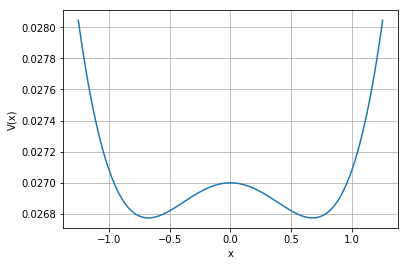

In [7]:
xv = np.linspace(-1.25, 1.25, 251)
pv = [potf(x, mass, spring) for x in xv]
plt.plot(xv, pv)
plt.xlabel("x")
plt.ylabel("V(x)")
plt.grid()
plt.show()

## Liikumisvõrrandite lahendamine

Liikumisvõrrandite lahendamiseks on meil lisaks dünaamikale ka algtingimusi vaja. Siin eeldame et alguses, $t = 0$, kehtib $x(0) = 0$ ja $v(0) = 0$.

In [8]:
y0 = [0.0, 0.0]

Järgmisena valime, millises ajavahemikus me soovime võrrandeid lahendada. Vahemik on valitud nii, et kui pendli liikumist konverteeritakse helifailiks, mida mängitakse 1800 korda kiirem kui päris võnkumist, siis helifaili kestus on 12s. Sellest järeldub, et pendli simulatsiooni kestus on 21600s, ehk 6 tundi. Lisaks defineerime audio diskreetimissagedus (*sampling rate*), tavaline valik on 44100 (heli CD).

In [9]:
smprt = 44100
speedup = 1800
duration = 12

Nende konstantidega defineerime ajavahemiku $T = [t_0, t_1]$, milles liikumisvõrrandeid lahendada.

In [10]:
time = speedup * duration
samples = duration * smprt + 1
nsmp = (int)(100 * smprt / speedup)
t = np.linspace(0, time, samples)

Lõpuks kasutame SymPy funktsiooni odeint võrrandite lahendamiseks.

In [11]:
sol = odeint(pend, y0, t, args = (mass, inertia, spring, ampl, freq, damp))
xsol = sol[:, 0]
vsol = sol[:, 1]

## Joonis: aeg ja pendli asukoht

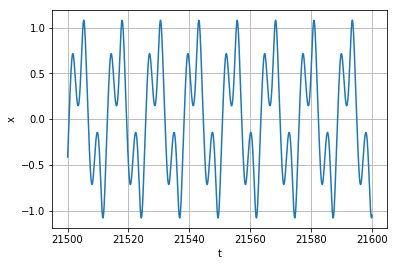

In [12]:
plt.plot(t[-nsmp:], xsol[-nsmp:])
plt.xlabel("t")
plt.ylabel("x")
plt.grid()
plt.show()

## Joonis: pendli asukoht ja kiirus

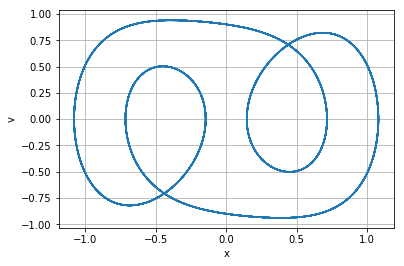

In [13]:
plt.plot(xsol[-nsmp:], vsol[-nsmp:])
plt.xlabel("x")
plt.ylabel("v")
plt.grid()
plt.show()

## Liikumise konverteerimine heliks

In [14]:
wfm = np.interp(xsol, [min(xsol), max(xsol)], [-1 * 2**15, 2**15 - 1]).astype(np.int16)
Audio(data=wfm, rate=smprt)

## Sageduse spekter

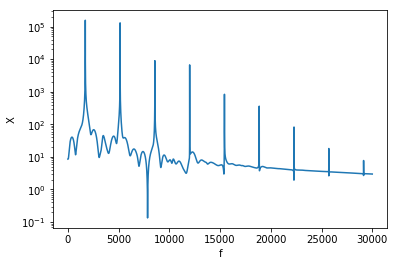

In [15]:
spec = np.absolute(np.fft.rfft(xsol))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xscale('linear')
ax.set_yscale('log')
ax.set_xlabel('f')
ax.set_ylabel('X')
ax.plot(spec[:30000])
plt.show()

## Küsimused

### Faasiruumi mõõde

Milline on (autonoomse süsteemi) faasiruumi mõõde?

* <input id="dim1" name="dim" class="bad" type="radio"><label for="dim1">1</label>
* <input id="dim2" name="dim" class="bad" type="radio"><label for="dim2">2</label>
* <input id="dim3" name="dim" class="good" type="radio"><label for="dim3">3</label>
* <input id="dim4" name="dim" class="bad" type="radio"><label for="dim4">4</label>

### Võnkumise omadused

Milline väide on vale?

* <input id="typeA" name="type" class="bad" type="radio"><label for="typeA">Kui hõõrdetegur on väike, ületab pendel potentsiaalibarjääri $x = 0$.</label>
* <input id="typeB" name="type" class="bad" type="radio"><label for="typeB">Pendli liikumine järeldub unikaalselt dünaamikast ja algtingimustest.</label>
* <input id="typeC" name="type" class="bad" type="radio"><label for="typeC">Kui hõõrdetegur on sobivalt valitud, on pendli liikumisvõrranditel perioodilised lahendid.</label>
* <input id="typeD" name="type" class="good" type="radio"><label for="typeD">Trajektoorid faasiruumis lõikavad üksteist.</label>